In [1]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from os import listdir
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DATA_PATH = "/kaggle/input/audio-rain-seq-8k"
Fs = 8000
model_name="seq_stft.hdf5"

In [3]:
def load_wav(file_path):
    audio, Fs = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=audio, sr=Fs)
    audio /= np.max(np.abs(audio), axis=0)
    return audio, Fs, duration

In [4]:
class Dataset:
    def __init__(self, data_path, output_shape, validation=False):
        self.data_path = data_path
        self.validation = validation
        self.output_shape = output_shape
        self.targets = np.load(self.data_path+"/target.npy")
        self.audio_files = [self.data_path+"/audio_{}".format(i)+".npy" for i in range(1, 201) if i!=171]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.audio_files, 
                                                                                self.targets,
                                                                            test_size=0.25)
    def __len__(self):
        if self.validation:
            data_len = int(np.ceil(len(self.y_test)))
        else:
            data_len = int(np.ceil(len(self.y_train)))
        return int(np.ceil(data_len ))
    
    def create_cnn_data(self, raw_data):
        stft_data = np.empty(shape=[0, 1025, 2657])
        Zxx = librosa.stft(raw_data)
        stft_sample = np.abs(Zxx)
        return stft_sample

    def __getitem__(self, index):
        if self.validation:
            audio_file = self.X_test[index]
            batch_target = self.y_test[index]
        else:
            audio_file = self.X_train[index]
            batch_target = self.y_train[index]
            
        audio_data = np.load(audio_file)
        audio_data = self.create_cnn_data(audio_data)
        batch_target = batch_target.reshape(self.output_shape)

        return audio_data, batch_target

In [5]:
class Dataloder(Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [6]:
output_shape = (1, 1)

In [7]:
EPOCHS = 25
BATCH_SIZE = 1

In [8]:
train_dataset = Dataset(DATA_PATH,
                        output_shape)

train_dataloader = Dataloder(train_dataset, 
                             batch_size=BATCH_SIZE)

test_dataset = Dataset(DATA_PATH,
                       output_shape,
                       validation=True)
test_dataloader = Dataloder(test_dataset, 
                            batch_size=BATCH_SIZE)

In [9]:
model = Sequential()
model.add(LSTM(50))
model.add(Dense(30))
model.add(Dense(10))
model.add(Dense(1))

In [10]:
cp_callback = ModelCheckpoint(filepath=model_name,
                              monitor="val_loss",
                              verbose=0,
                              save_best_only=True,
                              save_weights_only=True,
                              mode="min")

In [11]:
model.compile(optimizer='adam', loss="mean_squared_error", metrics=["mse"])

In [12]:
history = model.fit(train_dataloader,
                    validation_data=test_dataloader,
                    epochs=EPOCHS,
                    callbacks=[cp_callback])

Epoch 1/25
149/149 [==============================] - 42s 254ms/step - loss: 1.0610 - mse: 1.0610 - val_loss: 0.4497 - val_mse: 0.4497
Epoch 2/25
149/149 [==============================] - 23s 157ms/step - loss: 0.7304 - mse: 0.7304 - val_loss: 0.3228 - val_mse: 0.3228
Epoch 3/25
149/149 [==============================] - 21s 139ms/step - loss: 0.4034 - mse: 0.4034 - val_loss: 0.3178 - val_mse: 0.3178
Epoch 4/25
149/149 [==============================] - 23s 156ms/step - loss: 0.1495 - mse: 0.1495 - val_loss: 0.1399 - val_mse: 0.1399
Epoch 5/25
149/149 [==============================] - 22s 150ms/step - loss: 0.1130 - mse: 0.1130 - val_loss: 0.0995 - val_mse: 0.0995
Epoch 6/25
149/149 [==============================] - 24s 158ms/step - loss: 0.0811 - mse: 0.0811 - val_loss: 0.0418 - val_mse: 0.0418
Epoch 7/25
149/149 [==============================] - 23s 153ms/step - loss: 0.0719 - mse: 0.0719 - val_loss: 0.0616 - val_mse: 0.0616
Epoch 8/25
149/149 [==============================] - 2

In [13]:
def plot_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("log Loss")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

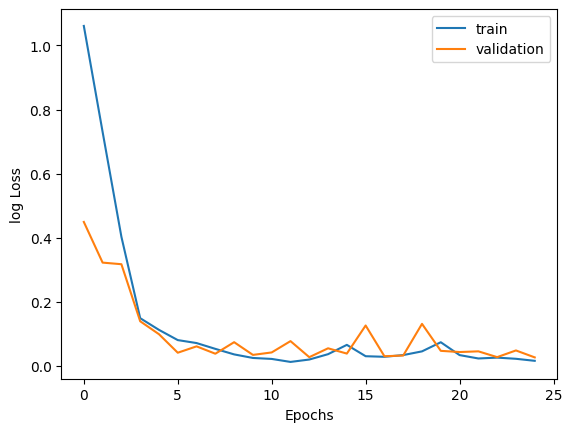

In [14]:
plot_history(history)

In [15]:
model.load_weights(model_name)

In [16]:
y_preds = []
y_tests = []
for i in range(50):
    X_test, y_test = test_dataloader.__getitem__(i)
    y_tests.append(y_test[0][0][0])
    y_pred = model.predict(X_test, verbose=0)[0][0]
    y_preds.append(y_pred)
result_df = pd.DataFrame()
result_df["y_tests"] = y_tests
result_df["y_preds"] = y_preds

In [17]:
# result_df = result_df[result_df["y_tests"]!=0]

Text(0, 0.5, 'Rainfall acoustic (mm) (estimated)')

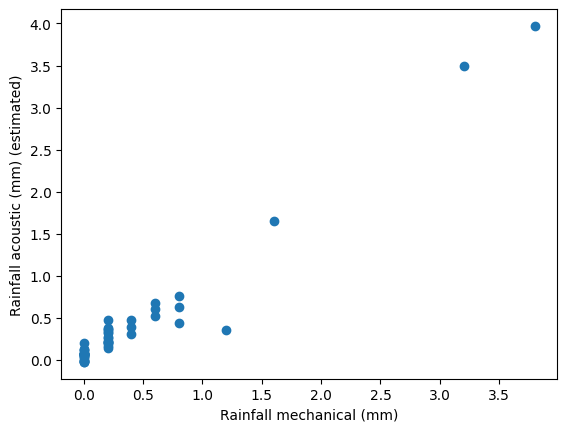

In [18]:
plt.scatter(result_df["y_tests"], result_df["y_preds"])
plt.xlabel("Rainfall mechanical (mm)")
plt.ylabel("Rainfall acoustic (mm) (estimated)")

In [19]:
result_df

,y_tests,y_preds
0,0.2,0.361212
1,0.2,0.379939
2,0.8,0.758135
3,0.0,0.065725
4,0.0,0.062250
5,0.2,0.205345
6,0.0,0.066118
7,0.4,0.299449
8,0.0,0.007815
9,0.8,0.622258


In [20]:
result = result_df[(result_df["y_tests"]!=0.0)]
A = result["y_tests"]
F = result["y_preds"]
N = result.shape[0]
MAPE = np.sum(abs((A-F)/(A+0.00001)))*100/N
print("Mean Absolute Percentage Error: {}%".format(np.round(MAPE, 3)))

Mean Absolute Percentage Error: 31.154%
